In this notebook, we use xgboost to predict the popularity of online news. 

A popularity score for a news website is quantified by how many "shares" in the social network does that news article generate.

The task here is to predict the popularity score, given the features of the news article. 

The data set can be downloaded from the UCI repository:
https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity


In [14]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sbn
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

pd.options.display.max_columns = 100

In [2]:
colnames = ['url', 
            'timedelta', 
            'n_tokens_title', 
            'n_tokens_content', 
            'n_unique_tokens', 
            'n_non_stop_words', 
            'n_non_stop_unique_tokens', 
            'num_hrefs', 
            'num_self_hrefs', 
            'num_imgs', 
            'num_videos', 
            'average_token_length', 
            'num_keywords', 
            'data_channel_is_lifestyle', 
            'data_channel_is_entertainment', 
            'data_channel_is_bus', 
            'data_channel_is_socmed', 
            'data_channel_is_tech', 
            'data_channel_is_world', 
            'kw_min_min', 
            'kw_max_min', 
            'kw_avg_min', 
            'kw_min_max', 
            'kw_max_max', 
            'kw_avg_max', 
            'kw_min_avg', 
            'kw_max_avg', 
            'kw_avg_avg', 
            'self_reference_min_shares', 
            'self_reference_max_shares', 
            'self_reference_avg_sharess',
            'weekday_is_monday', 
            'weekday_is_tuesday', 
            'weekday_is_wednesday', 
            'weekday_is_thursday',
            'weekday_is_friday', 
            'weekday_is_saturday', 
            'weekday_is_sunday', 
            'is_weekend',
            'LDA_00', 
            'LDA_01', 
            'LDA_02', 
            'LDA_03', 
            'LDA_04', 
            'global_subjectivity', 
            'global_sentiment_polarity', 
            'global_rate_positive_words', 
            'global_rate_negative_words',
            'rate_positive_words', 
            'rate_negative_words', 
            'avg_positive_polarity', 
            'min_positive_polarity', 
            'max_positive_polarity', 
            'avg_negative_polarity', 
            'min_negative_polarity', 
            'max_negative_polarity', 
            'title_subjectivity', 
            'title_sentiment_polarity',
            'abs_title_subjectivity', 
            'abs_title_sentiment_polarity', 
            'shares']


In [3]:
len(colnames)

61

In [4]:
data = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv', names=colnames, skiprows=1)
features = colnames[2:-1]
target = colnames[-1]

In [5]:
data.head(3)

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.5,-0.1875,0.0,0.1875,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.0,0.0000,0.5,0.0000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.0,0.0000,0.5,0.0000,1500


First we check the distribution of the target. As can be seen from the plots below, we see an obvious long-tail phenomena: most of the websites have low scores, but some rare websites can generate tremendous popularity. 

In light of this phenomena, when doing the regression, I chose to log-transform the target so that the regression is on the features and the log(shares). 

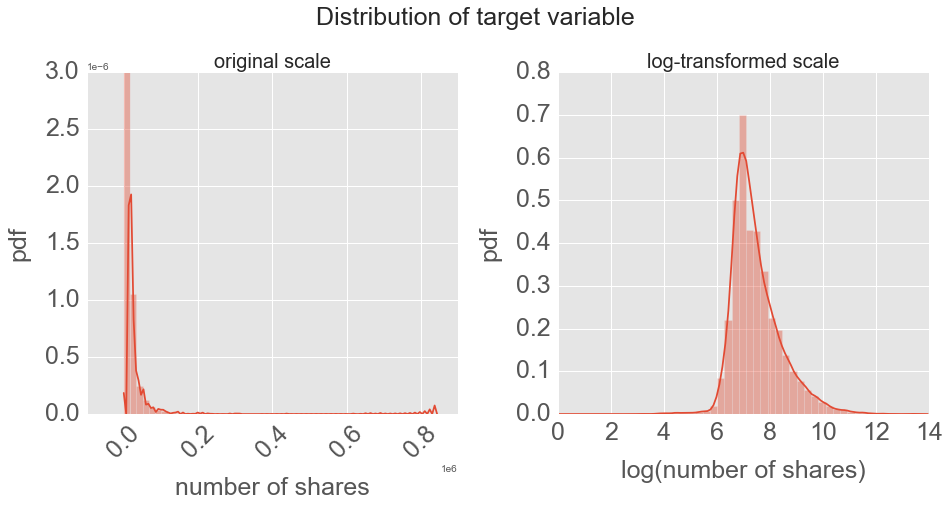

In [94]:
FONTSIZE = 25
plt.close('all')
fig = plt.figure(figsize=(13, 7))
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax = ax = plt.subplot(gs[0, 0])    
sbn.distplot(data[target], ax=ax) 
ax.set_xlabel('number of shares', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('pdf', fontsize=FONTSIZE, labelpad=15)
ax.set_ylim(0, 0.000003)
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(45)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)        
ax.set_title('original scale', fontsize=0.8*FONTSIZE)


ax = ax = plt.subplot(gs[0, 1])
ax = sbn.distplot(np.log(data[target]), ax=ax) 
ax.set_xlabel('log(number of shares)', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('pdf', fontsize=FONTSIZE, labelpad=15)
ax.set_xlim(0)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)        
ax.set_title('log-transformed scale', fontsize=0.8*FONTSIZE)

plt.tight_layout(pad=0, w_pad=2.0, h_pad=1.0)  
fig.suptitle('Distribution of target variable', fontsize=FONTSIZE)
plt.subplots_adjust(top=0.85)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.25)

In [8]:
X_train.shape, X_test.shape

((29733, 58), (9911, 58))

In [32]:
xgbm = XGBRegressor(n_estimators=300, nthread=4)
params_dist = {'max_depth': [3, 4, 8, 12, 15], 
               'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1], 
               'subsample': [0.4, 0.6, 0.8], 
               'colsample_bytree': [0.5, 0.75, 1.0], 
               'reg_lambda': [1, 2, 10, 20, 100]}

n_iter_search = 20
random_search = RandomizedSearchCV(xgbm, param_distributions=params_dist, n_iter=n_iter_search)

start_time = datetime.datetime.now()
random_search.fit(X_train, np.log(y_train))
elapsed_time = datetime.datetime.now() - start_time
print(elapsed_time)
xgbm = random_search.best_estimator_

In [34]:
xgbm

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.03, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=300, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=20,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

In [39]:
params = random_search.best_params_
params['nthread'] = 4

In [ ]:
n_estimators_list = np.arange(10, 3000, 50)
train_error = []
test_error = []
previous_n_estimators = 0
previous_model = None
start_time = datetime.datetime.now()
for n in n_estimators_list:
    if not previous_model:
        params['n_estimators'] = n
        model = XGBRegressor(**params)
    else:
        params['n_estimators'] = n - previous_n_estimators
        params['base_score'] = previous_model.predict(X_train)
        model = XGBRegressor(**params)
    model.fit(X_train, np.log(y_train))
    train_error.append(mean_squared_error(np.log(y_train), model.predict(X_train)))
    test_error.append(mean_squared_error(np.log(y_test), model.predict(X_test)))
    previous_n_estimators = n
    previous_moded = model
    print('n = {0:} finished'.format(n))
n_estimators_list = np.arange(10, 3000, 50)[0:len(test_error)]    
elapsed_time = datetime.datetime.now() - start_time
print(elapsed_time)

In [11]:
xgbm.get_params()
xgbm.get_xgb_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': -1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}

In [76]:
xgb_params = params.copy()
xgb_params.pop('n_estimators', None)
start_time = datetime.datetime.now()
xgtrain = xgb.DMatrix(X_train.values, label=np.log(y_train.values))
cvresult = xgb.cv(xgb_params, xgtrain, num_boost_round=1000, nfold=5, metrics='rmse', early_stopping_rounds=50)
elapsed_time = datetime.datetime.now() - start_time

best_n_estimators = len(cvresult)

params['n_estimators'] = best_n_estimators

xgbm = XGBRegressor(**params)
xgbm.fit(X_train, np.log(y_train))

print(elapsed_time)


0:02:56.819850


In [77]:
xgbm

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.03, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=324, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=20,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

In [96]:
cvresult.tail(3)

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
321,0.849512,0.005608,0.537265,0.003412
322,0.849480,0.005654,0.536214,0.003218
323,0.849468,0.005656,0.535463,0.003100


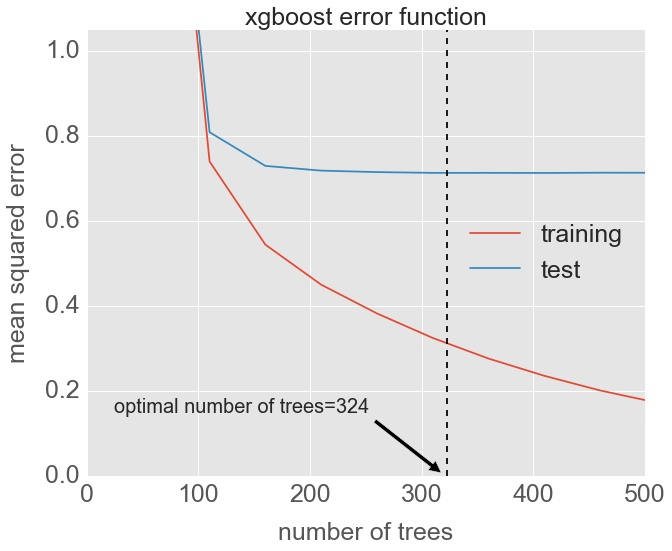

In [97]:
FONTSIZE=25
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10, 8))
p_train, = ax.plot(n_estimators_list, train_error)
p_test, = ax.plot(n_estimators_list, test_error)
lowest_test_error, = ax.plot([best_n_estimators-1, best_n_estimators-1], 
                             [0, 20], linestyle='--', color='k')
ax.set_xlabel('number of trees', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('mean squared error', fontsize=FONTSIZE, labelpad=15)
ax.set_xlim(0, 500)
ax.set_ylim(0, 1.05)                                         
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
l = plt.legend((p_train, p_test), ('training', 'test'), fontsize=FONTSIZE, loc=7)
ax.set_title('xgboost error function', fontsize=FONTSIZE)

ax.annotate('optimal number of trees={0:}'.format(best_n_estimators), 
            xy=(best_n_estimators-3, 0), xytext=(best_n_estimators-300, 0.15),
            fontsize=FONTSIZE*0.8,
            arrowprops=dict(facecolor='black', shrink=0.05),
            )


In [102]:
feature_importances = xgbm.booster().get_fscore()
importances = [feature_importances[f] for f in features]


In [122]:
def plotFeatureImportances(features, importances, cutoff=30):
    
    sorted_idx = np.argsort(importances)
    features = np.array(features)[sorted_idx]
    features = features[::-1]
    importances = np.array(importances)[sorted_idx]
    importances = importances[::-1]
    
    if len(features) > cutoff:        
        features = features[0:cutoff]
        importances = importances[0:cutoff]
    
    FONTSIZE = 20
    plt.close('all')
    fig, ax = plt.subplots(1, figsize=(16, 7))
    ind = np.arange(len(features))
    ax.bar(ind, importances, align='center')
    ax.set_xlabel('feature', fontsize=FONTSIZE, labelpad=15)
    ax.set_ylabel('importance', fontsize=FONTSIZE, labelpad=15)
    ax.set_xlim(-1, len(features))
    ax.set_xticks(ind)
    ax.set_xticklabels(features)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FONTSIZE*0.9)
        tick.label.set_rotation(90)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(FONTSIZE)
        tick.label.set_rotation(0)
    ax.set_title('top {0:} feature importances'.format(cutoff), fontsize=FONTSIZE)
    

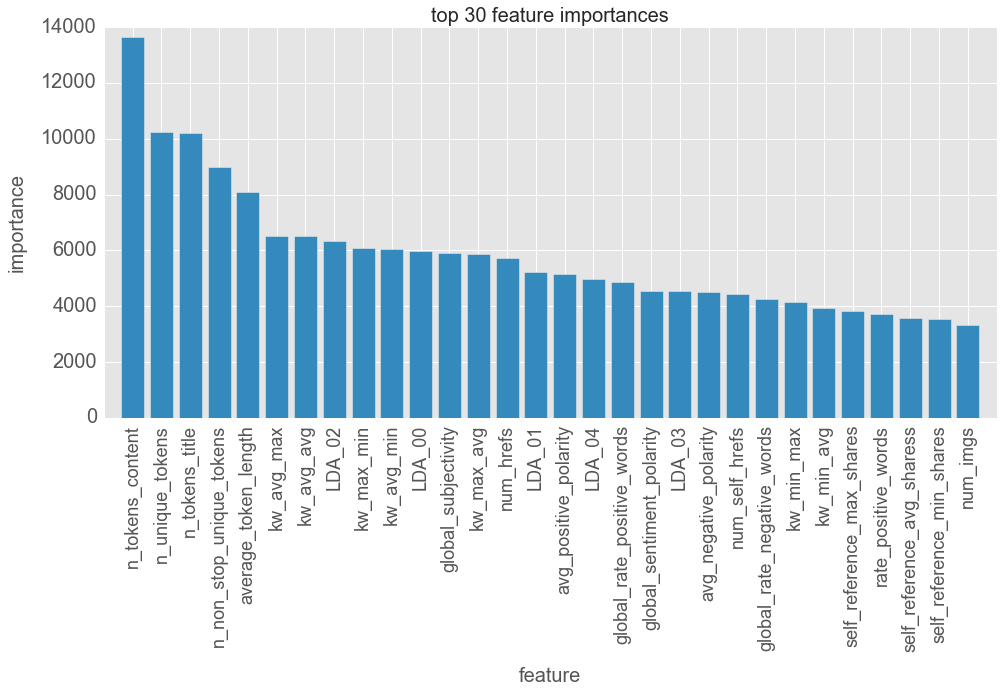

In [123]:
plotFeatureImportances(features, importances)